# Which version of the website should you use?

## 📖 Background
You work for an early-stage startup in Germany. Your team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join your site. 

They have been testing the changes for a few weeks and now they want to measure the impact of the change and need you to determine if the increase can be due to random chance or if it is statistically significant.

## 💾 The data
The team assembled the following file:

#### Redesign test data
- "treatment" - "yes" if the user saw the new version of the landing page, no otherwise.
- "new_images" - "yes" if the page used a new set of images, no otherwise.
- "converted" - 1 if the user joined the site, 0 otherwise.

The control group is those users with "no" in both columns: the old version with the old set of images.

In [1]:
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.formula.api import ols
import statsmodels.api as sm

np.random.seed(42)

In [2]:
df = pd.read_csv('./data/redesign.csv')
df.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


## 💪 Challenge
Complete the following tasks:

1. Analyze the conversion rates for each of the four groups: the new/old design of the landing page and the new/old pictures.
2. Can the increases observed be explained by randomness? (Hint: Think A/B test)
3. Which version of the website should they use?

## 🧑‍⚖️ Judging criteria

We will randomly select ten winners from the correct submissions for this challenge.

The winners will receive DataCamp merchandise.

## ✅ Checklist before publishing
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- Remove redundant cells like the judging criteria, so the workbook is focused on your answers.
- Check that all the cells run without error.

## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


* there are not nulls, the types are o.k.
* there is no place in such dataset to check duplicates ....

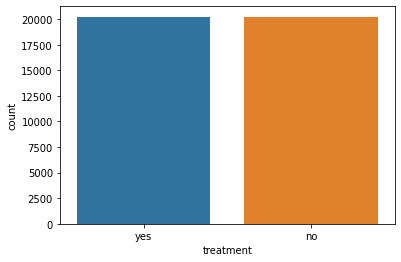

In [4]:
sns.countplot(df['treatment']);

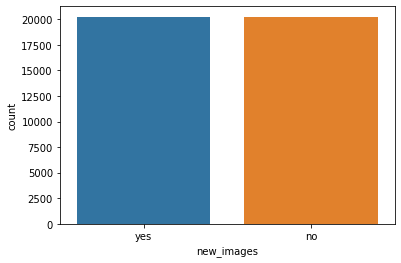

In [5]:
sns.countplot(df['new_images']);

* the seperation seems O.K.!

## Convertion rates:

In [6]:
def calculate_convertion_rates(treatment,new_images):
    relevant = df[(df['treatment']==treatment) & (df['new_images']==new_images)]
    return {'conversion rate':np.round(relevant["converted"].sum()/len(relevant),5), 'group size':len(relevant)}


### group 1 - control group (no treatment, old set)

In [7]:
calculate_convertion_rates('no','no')   

{'conversion rate': 0.1071, 'group size': 10121}

### group 2 - treatment, old set

In [8]:
calculate_convertion_rates('yes','no')  

{'conversion rate': 0.12005, 'group size': 10121}

### group 3 - no treatment, new set

In [9]:
calculate_convertion_rates('no','yes')  

{'conversion rate': 0.11254, 'group size': 10121}

### group 4 treatment, new set.

In [10]:
calculate_convertion_rates('yes','yes')  

{'conversion rate': 0.11372, 'group size': 10121}

* we see the differnt convertion rates, we see too that the group sizes are equal.

## A/B testing

### * i have been helped <a href="https://towardsdatascience.com/ab-testing-with-python-e5964dd66143"> by this article. </a>

* we have here multivarient testing. if we will use regular alpha value (5%), because of the two variables, we will get higher ratio of False Posisitives (type 1 error). because we have two variables the new alpha acually will be: 
$$1 - (1-0.05)^2 = 0.097 $$
* so we will use the "Bonferroni correction", that means we will divide alpha by the number of the variables. we have two variables, so we will use:
$$ \alpha = 0.05/2 = 0.025$$

    Hₒ: p = pₒ
    Hₐ: p ≠ pₒ   

where p and pₒ stand for the conversion rate of the new and old design, respectively. We’ll also set a confidence level of 97.5%:
$$    α = 0.025$$

So how many people should we have in each group?

The sample size we need is estimated through something called Power analysis, and it depends on a few factors:

    Power of the test (1 — β) — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention (here’s more info on statistical power, if you are curious)
    Alpha value (α) — The critical value we set earlier to 0.025
    Effect size — How big of a difference we expect there to be between the conversion rates
the current conversion rate is about 10.7% (the controll group)
Since our team would be happy with a difference of 1%, we can use 11% and 12% to calculate the effect size we expect.

In [11]:
effect_size = sms.proportion_effectsize(0.11, 0.12) 
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.025, 
    ratio=1
    ) 
required_n = math.ceil(required_n)            

print('the sample size we need: ',required_n)

the sample size we need:  19339


* We’d need at least 19339 observations for each group - we have like 20K (see in the countplots above) so this is O.K.
* we shouldn't resamle the data, because we have already equal groups.

* Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (11% vs. 12%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.
* about ratio=1 in sample size calculation - The documentation from statsmodels defines it as "ratio of the number of observations in sample 2 relative to sample 1". Essentially, you input the sample size for group 1 in the function and indicate sample size for group 2 as a ratio of group 1. In this case they are the same, hence ratio=1
* we will use z-test and not t test because of this <a href="https://stats.stackexchange.com/questions/90893/why-use-a-z-test-rather-than-a-t-test-with-proportional-data">answer</a>.

In [12]:
control_results = df[df['treatment']=='no']['converted']
treatment_results = df[df['treatment']=='yes']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.025)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.24
p-value: 0.025
ci 95% for control group: [0.105, 0.115]
ci 95% for treatment group: [0.112, 0.122]


* our p value is equal to our alpha, and there is a overlapping on the Ci's, so i think we should accept the null hypothesis, we didn't approved a significant difference between the combinations of treatment with new images or without.
* but if we were checking only the treatment effect, no matter old or new images, we were rejecting the null hypothesis with alpha of 5%.

In [13]:

control_results = df[df['new_images']=='no']['converted']
treatment_results = df[df['new_images']=='yes']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.025)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.14
p-value: 0.888
ci 95% for control group: [0.109, 0.119]
ci 95% for treatment group: [0.108, 0.118]


* our p value is high above alpha, we should accept the null hypothesis, we didn't approved a significant difference between them.

### Anova testing

* when we checked these two features independetly, we accepted the null hypothesis. but maybe we should check all the 4 groups because of combined effect ? so we will do anova tesing too.

In [14]:
model = ols('converted~treatment+new_images+treatment*new_images',data= df).fit()

In [15]:
variance_analysis = sm.stats.anova_lm(model,type=3)
variance_analysis

,df,sum_sq,mean_sq,F,PR(>F)
treatment,1.0,0.505113,0.505113,5.026342,0.024970
new_images,1.0,0.002001,0.002001,0.019910,0.887790
treatment:new_images,1.0,0.349793,0.349793,3.480758,0.062094
Residual,40480.0,4067.964233,0.100493,NaN,NaN


* about anova types - <a href="https://www.r-bloggers.com/2011/03/anova-%e2%80%93-type-iiiiii-ss-explained/"> here</a>
* the results of the p value (last column) are pretty same like the p values from the z tests. 
* the interaction between the two variables, isn't signinficant.

## Conclusions:

1. Can the increases observed be explained by randomness? 
    * the answer is yes for the new images - its only random.
    * for the treatment we could say that there is a significant effect with alpha of 5%, but not for the combinations with the images.
3. Which version of the website should they use?
    * we should use the treatment version, dont matter old or new images. 